#### TEST

1. 단위 테스트

테스트 단위의 크기를 작게 설정해서 최대한 간단하게 작성함. & TDD와 결합시 강력

2. 통합 테스트

모듈의 여러개를 합쳐 의도대로 동작하는지 확인하는 것 & 어려운 버그를 찾을 수 있는 장점

하지만 어디서 에러가 발생했는 지 확인하기 어렵다는 단점

### 단위 테스트

unit test 라이브러리 사용

test시 test로 시작하는 메서드를 만듬(규칙)


In [10]:
import unittest
import numpy as np

class SquareTest(unittest.TestCase):
  def test_forward(self):
    x = Variable(np.array(2.0))
    y = square(x)
    expected = np.array(4.0)
    self.assertEqual(y.data, expected)

### Square 역전파 테스트

: test backward 메서드 추가

backward를 이용하여 미분 값 -> 기대 값 일치 확인

## 자동 테스트
: 기울기 확인을 이용

수치 미분과 역전파 비교 -> 차이 ↑(역전파 구현 문제)

In [11]:
def numerical_diff(f, x, eps = 1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

In [12]:
def test_gradient_check(self):
  x = Variable(np.random.rand(1))
  y = square(x)
  y.backward()
  num_grad = numberical_diff(square, x)
  flg = np.allclose(x.grad, num_grad)
  self.assertTrue(flg)

### 가변 길이 인수(순전파)
: 많은 variable 입력 가능

: 부모 creator 필요

In [48]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

def set_creator(self, func):
  self.creator = func

def backward(self):
  if self.grad is None:
    self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

In [49]:
class Function:
  def __call__(self, inputs):
    xs = [x.data for x in inputs]
    ys = self.forward(xs) # *추가
    if not isinstance(ys, tuple):
      ys = (ys,)
    outputs = [Variable(as_array(y)) for y in ys]

    for output in outputs:
      output.set_creator(self) #부모 creator 지정
    self.inputs = inputs
    self.outputs = outputs
    return outputs

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, gy):
    raise NotImplementedError()

In [50]:
class Add(Function):
  def forward(self, xs):
    # y = x0 + x1
    # return y
    x0, x1 = xs
    y = x0 + x1
    return (y, )

In [51]:
xs = [Variable(np.array(2)), Variable(np.array(3))]
f = Add()
ys = f(xs)
y = ys[0]
print(y.data)

AttributeError: 'Variable' object has no attribute 'set_creator'

### Function 클래스 수정

: Add -> add 함수로 변경

: 함수 호출 시 * 사용(리스트를 다 풀어줌)

In [55]:
class Add(Function):
  def forward(self, x0, x1):
    y = x0 + x1
    return y

  def backward(self, gy):
    return gy, gy

In [56]:
def add(x0, x1):
  return Add()(x0, x1)

In [58]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

TypeError: Function.__call__() takes 2 positional arguments but 3 were given

In [59]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

def set_creator(self, func):
  self.creator = func

def backward(self):
  if self.grad is None:
    self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

In [60]:
#변경 후

class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

def set_creator(self, func):
  self.creator = func

def backward(self):
  if self.grad is None:
    self.grad = np.ones_like(self.data)

    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      gys = [output.grad for output in f.outputs]
      gxs = f.backward(*gys)
      if not isinstance(gxs, tuple):
        gxs = (gxs, )

      for x, gx in zip(f.inputs, gxs):
        x.grad = gx
      # x, y = f.input, f.output
      # x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

### 오류가 계속 뜸....

해결 방법을 찾아야함

In [61]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print('1. x.grad = ', x.grad)

TypeError: Function.__call__() takes 2 positional arguments but 3 were given

In [72]:
class Add(Function):
    def forward(self, *xs):
        if len(xs) != 2:
            raise ValueError("Add function expects exactly 2 arguments.")
        x0, x1 = xs
        y = x0 + x1
        return (y, )

In [73]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]

        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs

    def forward(self, x):
        raise NotImplementedError()

    def backward(self, gy):
        raise NotImplementedError()

In [74]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
f = Add()
y = f(x0, x1)[0]
print(y.data)

ValueError: Add function expects exactly 2 arguments.

In [76]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print('1. x.grad = ', x.grad)

x.cleargrad() #추가됨
y = add(x, x)
y.backward()
print('2. x.grad = ', x.grad)

ValueError: Add function expects exactly 2 arguments.

### 역전파 (가변 길이 인수)

: 덧셈의 역전파

- 상류에서 흘러나오는 미분 값을 그대로 보냄
(가중치 업데이트 방식)
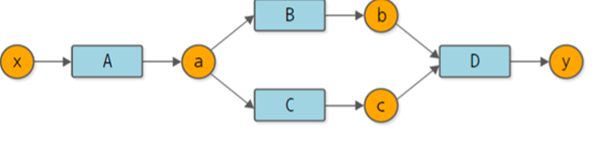
- D -> B or C -> A (올바른 순서로 처리시)

In [77]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None

  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

      funcs = [self.creator]

      while funcs:
        f = funcs.pop() #마지막 함수 값 소환하는 함수
        gys = [output.grad for output in f.outputs]
        gxs = f.backward(*gys)
        if not isinstance(gxs, tuple):
          gxs = (gxs, )

        for x, gx in zip(f.inputs, gxs):
          x.grad = gx

        if x.creator is not None:
          funcs.append(x.ceator)

###### 역전파의 경우 세대 수가 큰 쪽부터 처리하면 부모보다 먼저 처리됨
: 세대가 우선 순위에 해당된다는 뜻

### 순전파
: variable & Function에 (generation 추가)


In [83]:
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None
    self.generation = 0  #추가됨 -> 0으로 초기화

  def set_creator(self, func):
    self.creator = func
    self.generation = func.generation + 1 #set_creator 호출 시 함수의 세대보다 1만큼 크게 설정

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)

      funcs = [] #공백으로 바꿈
      seen_set = set() #추가됨

      while funcs:
        f = funcs.pop() #마지막 함수 값 소환하는 함수
        gys = [output.grad for output in f.outputs]
        gxs = f.backward(*gys)
        if not isinstance(gxs, tuple):
          gxs = (gxs, )

        for x, gx in zip(f.inputs, gxs):
          x.grad = gx

        if x.creator is not None:
          funcs.append(x.ceator)
  def add_func(f):
    if f not in seen_set:
      funcs.append(f)
      seen_set.add(f)
      funcs.sort(key=lambda x: x.generation)

  add_func(self.creator)

NameError: name 'self' is not defined

: 중첩 메서드 추가하면서 세대 별로 분류함